In [1]:
import torch as to
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import numpy as np
import mnist
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [39]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

train_images = train_images/255
train_images = to.from_numpy(train_images)
train_images = train_images.float()
train_labels = to.from_numpy(train_labels)
train_labels = train_labels.long()

valid_images=train_images[50000:, :, :].reshape(10000, 28*28)
valid_labels=train_labels[50000:]
train_images=train_images[:50000, :, :].reshape(50000, 28*28)
train_labels=train_labels[:50000]

train_ds, valid_ds = Dataset(train_images, train_labels), Dataset(valid_images, valid_labels)
assert len(train_ds)==len(train_images)
assert len(valid_ds)==len(valid_images)

epochs=10
bs=1000
m=train_images.shape[1]
nclass=len(np.unique(train_labels))
nh=50
nz=14*14
dsteps=1
gsteps=5

In [55]:
def datapoints_in_a_circle(n, spread):
    x= (np.random.rand(n)*2)-1
    y= np.sqrt(1-x**2) * np.random.choice([-1, 1], n)
    x = x + np.random.rand(n)*spread
    y= y + np.random.rand(n)*spread
    return x, y

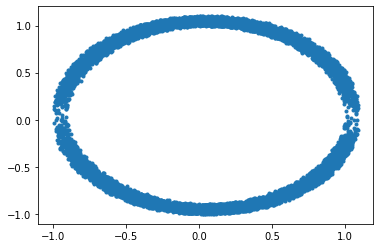

In [56]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

x, y = datapoints_in_a_circle(10000, 0.1)
data = np.array([x,y])
data = to.from_numpy(data)

plt.plot(x, y, '.')
plt.show()

In [67]:
def collate(b):
    xs,ys = zip(*b)
    return to.stack(xs),to.stack(ys)

data_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [68]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [75]:
Dlayers= [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10), nn.Sigmoid()]
Glayers= [nn.Linear(nz,nh), nn.ReLU(), nn.Linear(nh,28*28)]
D = Model(Dlayers)
G = Model(Glayers)



In [70]:
loss_func = nn.BCELoss()
def accuracy(out, yb): return (to.argmax(out, dim=1)==yb).float().mean()

In [71]:
lr=0.01
opt_g=optim.SGD(G.parameters(), lr=lr)
opt_d=optim.SGD(D.parameters(), lr=lr)

In [72]:
def fit(epochs, G, D, loss_func, opt_g, opt_d, train_dl, valid_dl):
    for epoch in range(epochs):
        for xb,yb in train_dl:
            for d in range(dsteps):
                D.train()
                G.eval()
                z=to.from_numpy(np.random.randn(bs, 14*14))
                z=z.float()
                dx_real = D(xb)
                dx_gen = D(G(z))                
                Dloss_real = loss_func(dx_real, to.ones((bs)))
                Dloss_gen = loss_func(dx_gen, to.zeros((bs)))
                Dloss=.5*Dloss_real+.5*Dloss_gen
                Dloss.backward()
                opt_d.step()
                opt_d.zero_grad()
            for g in range(gsteps):
                D.eval()
                G.train()                
                dx_gen = D(G(z))                
                Gloss = loss_func(dx_gen, to.ones((bs)))
                Gloss.backward()
                opt_g.step()
                opt_g.zero_grad()
                
        D.eval()
        G.eval()
        print('epoch: '+str(epoch+1))
#         print(model.training)


In [74]:
loss,acc = fit(5, G, D, loss_func, opt_g, opt_d, train_dl, valid_dl)

AttributeError: 'tuple' object has no attribute 'dim'

In [22]:
        with to.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy(pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

IndentationError: unexpected indent (<ipython-input-22-63bcf3d40501>, line 9)